In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# packages
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import time

# 1. Pubtator API (TODO-Partially done)
- using the input folder, check if the file(s) have been pre-annotated by checking if the following APIs return something
```
https://www.ncbi.nlm.nih.gov/research/pubtator3-api/publications/export/biocxml?pmids={id}
or
https://www.ncbi.nlm.nih.gov/research/pubtator3-api/publications/pmc_export/biocxml?pmcids=PMC{id}
```
  - if annotated, retrieve it and put it in the output folder
  - if not, use the [example code](https://www.ncbi.nlm.nih.gov/CBBresearch/Lu/Demo/tmTools/download/ExampleCode.Python.zip) they provide to send it to the server to be annotated (Done)

Using colab:

```
mkdir input
```

to make a input folder

In [4]:
!bash

bash: cannot set terminal process group (943): Inappropriate ioctl for device
bash: no job control in this shell
/content# mkdir input


/content# ^C


In [5]:
# SubmitText_request.py
!pip install unidecode

import requests
import os
import sys
from unidecode import unidecode
import unicodedata
import re

def submit_text_request(input_folder, bioconcept, output_file_session_number):
    pattern = r'[^0-9a-zA-Z\!\@\#\$\%\^\&\*\(\)\_\+\{\}\|\:\"\<\>\?\-\=\[\]\\;\'\,\.\/ \t\n\r]'
    unicode_to_regular = {}
    with open('unicode.txt', 'r', encoding='utf-8') as input_file:
        for line in input_file:
            line = line.strip()
            parts = line.split("\t")
            if len(parts) == 2:
                uni, reg = parts
                if reg == '-whitespace-':
                    unicode_to_regular[uni] = ' '
                else:
                    unicode_to_regular[uni] = reg

    with open(output_file_session_number, 'w', encoding='utf-8') as output_file:
        for filename in os.listdir(input_folder):
            if filename.startswith('.'):
                continue  # Skip hidden files
            text_str = ''
            with open(os.path.join(input_folder, filename), 'r', encoding='utf-8') as file_input:
                for line in file_input:
                    normalized_line = unicodedata.normalize('NFC', line)
                    for uni, reg in unicode_to_regular.items():
                        normalized_line = normalized_line.replace(uni, reg)
                    normalized_line = unidecode(normalized_line)  # Assuming unidecode does similar work to Perl's version
                    text_str += normalized_line
            text_str = re.sub(pattern, ' ', text_str)
            url = "https://www.ncbi.nlm.nih.gov/CBBresearch/Lu/Demo/RESTful/request.cgi"
            response = requests.post(url, data={'text': text_str, 'bioconcept': bioconcept})

            if response.status_code == 200:
                session_number = response.json().get('id', '')
                print(f"Thanks for your submission. The session number is: {session_number}")
                output_file.write(f"{session_number}\t{filename}\n")
            else:
                print(f"Error: HTTP {response.status_code} for {filename}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 19.5 MB/s eta 0:00:00


In [6]:
# SubmitText_retreive.py
import requests
import os
import sys

def submit_text_retrieve(input_folder, inputfile_session_number, output_folder):
    # Ensure output directory exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    sn_hash = {}
    with open(inputfile_session_number, 'r') as input_file:
        for line in input_file:
            line = line.strip()
            if line:
                session_number, input_filename = line.split("\t")
                sn_hash[session_number] = input_filename

    base_url = "https://www.ncbi.nlm.nih.gov/CBBresearch/Lu/Demo/RESTful/retrieve.cgi"

    for session_number, input_filename in sn_hash.items():
        output_file_path = os.path.join(output_folder, input_filename)
        if os.path.exists(output_file_path):
            print(f"{output_file_path} - finished")
            continue

        retrieve_url = f"{base_url}?id={session_number}"
        response = requests.get(retrieve_url)
        if response.status_code == 200:
            with open(output_file_path, 'w', encoding='utf-8') as output_file:
                output_file.write(response.text)
            print(f"{session_number} : Result is retrieved.")
        else:
            print(f"{session_number} : Error retrieving results - {response.status_code}")


In [32]:
input_folder = "input"       # pull xml,json, or pubtator formatted files here to be annotated
bioconcept = "Gene"                                         # we only want the genes
output_file_session_number = "Session_Number.txt"  # output file for session number which will be used to retrieve the results
submit_text_request(input_folder, bioconcept, output_file_session_number)    # submit the text for annotation

Thanks for your submission. The session number is: 660BBC06624217CF1139
Thanks for your submission. The session number is: DA86F95D7B63ADCC9670
Thanks for your submission. The session number is: C248D4340D240A918E53
Thanks for your submission. The session number is: C3C733D252D9EB461F23


## Running the code below takes time, so it might say error 400. Just rerun it a bit later.

In [36]:
input_folder = "input"
inputfile_session_number = "Session_Number.txt"
output_folder = "output"
submit_text_retrieve(input_folder, inputfile_session_number, output_folder)


output/ex.PubTator - finished
DA86F95D7B63ADCC9670 : Result is retrieved.
output/ex.BioC.xml - finished
output/ex.json - finished


# 2. Relevance (Done)
- This can be integrated with Gene Chunking. We can just check if the paper has genes (i.e check if there is an item in the dictionary @ line 171)

*3. Gene Chunking*
=============
Given a **preannotated** article (check input folder) analyze the **XML** file via `parse_xml_file(xml_file_path)` which returns a dictionary of "Gene Class" from that file  

The Gene Class has the following information:
- self.gene_id: the gene id (from the xml file)
- self.occurences: A list of occurences of the gene in the text. Each occurence is **3-sentences long**.
    - The second sentence contains the explicit mention of the gene.
    - The first and third sentences are the context of the gene mention.
- self.symbol: the gene symbol (from NCBI. Initialized to None)
- self.organism: the organism of the gene (from NCBI. Initialized to None)
- self.full_name: the full name of the gene (from NCBI. Initialized to None. Set to name_from_article if not found in NCBI)
- self.also_known_as: a list of other names of the gene (from NCBI. Initialized to None. Set to name_from_article if not found in NCBI)
- self.name_from_article: the name of the gene as found in the article

Steps:
1. define the class Gene
2. Parse the xml file
3. update the Gene class with the information from NCBI
Now you have a dictionary of Gene classes.~

TIPS:
- control + F "sentence_buffer" to find where you can adjust the buffer

In [37]:
!pip install biopython
import xml.etree.ElementTree as ET
from Bio import Entrez
import re
import time

class Gene:
    def __init__(self, gene_id):
        self.gene_id = gene_id
        self.occurrences = []  # list to store snippet(s) where the gene was mentioned
        self.symbol = None
        self.organism = None
        self.full_name = None
        self.also_known_as = None
        self.name_from_article = None
        # TODO: add pmid/pmcid which will be used for final output.

    def add_occurrence(self, snippet):
        if snippet not in self.occurrences:  # Avoid duplicates
            self.occurrences.append(snippet)

    def set_name_from_article(self, name_from_article):
        """Sets the temporary name of the gene. This is the name according to the article"""
        self.name_from_article = name_from_article

    def get_name_from_article(self):
        return self.name_from_article

    def get_occurrences(self):
        return self.occurrences

    def get_also_known_as(self):
        return self.also_known_as

    def get_gene_id(self):
        return self.gene_id

    def update_info(self, symbol, organism, full_name, also_known_as):
        self.symbol = symbol
        self.organism = organism
        self.full_name = full_name
        self.also_known_as = also_known_as

    def __repr__(self):
        return (f"Gene({self.gene_id})\n"
                f"  Symbol          : {self.symbol}\n"
                f"  Organism        : {self.organism}\n"
                f"  Full Name       : {self.full_name}\n"
                f"  Also Known As   : {self.also_known_as}\n"
                f"  In-text Name    : {self.name_from_article}\n"
                f"  Occurrences     : {self.occurrences}")

def parse_xml_file(xml_path):
    """Parses the XML file and returns a gene dictionary keyed by gene ID."""
    tree = ET.parse(xml_path)
    root = tree.getroot()
    gene_dict = {}

    for document in root.findall('document'):
        for passage in document.findall('passage'):
            section_type_elem = passage.find("infon[@key='section_type']")
            if section_type_elem is not None and section_type_elem.text and section_type_elem.text.upper() in ("METHODS", "FIG", "TABLE"):
                continue  # Skip passages under METHODS
            # Get the full passage text.
            passage_text_elem = passage.find("text")
            passage_text = passage_text_elem.text if passage_text_elem is not None else ""
            # Determine the starting offset for this passage.
            passage_offset_elem = passage.find("offset")
            passage_offset = int(passage_offset_elem.text) if passage_offset_elem is not None else 0
            # Split the passage into sentences using regex.
            sentences = re.split(r'(?<=[.!?])\s+', passage_text)
            # Compute start indices for each sentence within the passage text.
            start_indices = []
            current_index = passage_offset
            for sentence in sentences:
                start_indices.append(current_index)
                current_index += len(sentence) + 1  # account for the delimiter space

            # Dictionary to store annotations per gene in this passage.
            # For each gene_id, we collect the sentence indices and a temporary in-text name.
            gene_annotations = {}
            for annotation in passage.findall('annotation'):
                ann_type = annotation.find("infon[@key='type']")
                if ann_type is not None and ann_type.text == "Gene":
                    # Check for both 'identifier' and 'NCBI Gene' keys.
                    gene_id_elem = annotation.find("infon[@key='identifier']")
                    if gene_id_elem is None:
                        gene_id_elem = annotation.find("infon[@key='NCBI Gene']")
                    gene_id = gene_id_elem.text if gene_id_elem is not None else None

                    # Handle multiple IDs by keeping only the first if needed.
                    if gene_id and ";" in gene_id:
                        gene_id = gene_id.split(";")[0].strip()

                    # Extract the gene name from the annotation text.
                    in_text_gene_name_elem = annotation.find("text")
                    in_text_gene_name = in_text_gene_name_elem.text if in_text_gene_name_elem is not None else None

                    # Extract the annotation location (offset) to find the sentence.
                    location_elem = annotation.find("location")
                    ann_offset = int(location_elem.attrib.get('offset', 0)) if location_elem is not None else 0

                    # Determine which sentence contains the annotation based on its offset.
                    sentence_index = None
                    for i, start in enumerate(start_indices):
                        if start <= ann_offset < start + len(sentences[i]):
                            sentence_index = i
                            break

                    if sentence_index is not None and gene_id:
                        if gene_id not in gene_annotations:
                            gene_annotations[gene_id] = {'indices': [], 'name': in_text_gene_name}
                        gene_annotations[gene_id]['indices'].append(sentence_index)

            # For each gene in this passage, process the annotation indices.
            for gene_id, data in gene_annotations.items():
                # Remove duplicate indices and sort.
                indices = sorted(set(data['indices']))
                candidate_windows = []
                # For each annotation occurrence, form a candidate window:
                # one sentence before and one sentence after the annotated sentence.
                for idx in indices:
                    start_sentence = max(0, idx - 1)
                    end_sentence = min(len(sentences), idx + 2)  # end index is non-inclusive
                    candidate_windows.append((start_sentence, end_sentence))
                # Merge overlapping candidate windows.
                merged_windows = []
                for window in sorted(candidate_windows):
                    if not merged_windows:
                        merged_windows.append(window)
                    else:
                        last = merged_windows[-1]
                        # If windows overlap or touch, merge them.
                        if window[0] <= last[1]:
                            merged_windows[-1] = (last[0], max(last[1], window[1]))
                        else:
                            merged_windows.append(window)
                # For each merged window, if it spans more than 3 sentences, split it into chunks of 3 sentences maximum.
                for window in merged_windows:
                    start, end = window
                    window_size = end - start
                    if window_size <= 3:
                        snippet = " ".join(sentences[start:end])
                        if gene_id in gene_dict:
                            gene_dict[gene_id].add_occurrence(snippet)
                        else:
                            gene_obj = Gene(gene_id)
                            gene_obj.add_occurrence(snippet)
                            gene_obj.set_name_from_article(data['name'])
                            gene_dict[gene_id] = gene_obj
                    else:
                        # Split the merged window into non-overlapping chunks of at most 3 sentences.
                        for i in range(start, end, 3):
                            chunk_end = min(i + 3, end)
                            snippet = " ".join(sentences[i:chunk_end])
                            if snippet.strip():
                                if gene_id in gene_dict:
                                    gene_dict[gene_id].add_occurrence(snippet)
                                else:
                                    gene_obj = Gene(gene_id)
                                    gene_obj.add_occurrence(snippet)
                                    gene_obj.set_name_from_article(data['name'])
                                    gene_dict[gene_id] = gene_obj
    return gene_dict

def fetch_and_update_gene_info(gene_dict):
    """Retrieves gene information from NCBI and updates the genes in gene_dict."""
    gene_ids = list(gene_dict.keys())
    if gene_ids:
        # Post the gene IDs to NCBI.
        handle = Entrez.epost(db="gene", id=",".join(gene_ids))
        result = Entrez.read(handle)
        handle.close()

        webenv = result["WebEnv"]
        query_key = result["QueryKey"]

        handle = Entrez.esummary(db="gene", webenv=webenv, query_key=query_key)
        record = Entrez.read(handle)
        handle.close()

        for docsum in record["DocumentSummarySet"]["DocumentSummary"]:
            gene_id = docsum.attributes["uid"]
            symbol = docsum.get('NomenclatureSymbol', 'No symbol')
            organism = docsum.get('Organism', {}).get('ScientificName', 'No organism')
            full_name = docsum.get('NomenclatureName', gene_dict[gene_id].get_name_from_article())
            also_known_as = docsum.get('OtherAliases', gene_dict[gene_id].get_name_from_article())

            if full_name == '':
                full_name = gene_dict[gene_id].get_name_from_article()
            if also_known_as == '':
                also_known_as = gene_dict[gene_id].get_name_from_article()

            if gene_id in gene_dict:
                gene_dict[gene_id].update_info(symbol, organism, full_name, also_known_as)
            time.sleep(0.5)  # Pause briefly to avoid overwhelming NCBI servers.

# Set your email (and API key if available)
Entrez.email = "email here"
# Entrez.api_key = "your_api_key"

xml_path = "output/PMC9406740.xml"
gene_dict = parse_xml_file(xml_path)
fetch_and_update_gene_info(gene_dict)  # Optionally fetch gene info from NCBI

print("There are {} genes in the paper.".format(len(gene_dict)))
if len(gene_dict) == 0:
    print("No genes found in the paper.")
else:
    for gene in gene_dict.values():
        print(gene)
        print(f"There are {len(gene.get_occurrences())} occurrence(s) (each occurrence is at most 3 sentences long) for gene {gene.get_gene_id()} : {gene.get_name_from_article()}.")
        print("")


There are 116 genes in the paper.
Gene(433766)
  Symbol          : Trim63
  Organism        : Mus musculus
  Full Name       : tripartite motif-containing 63
  Also Known As   : MuRF1, RF1, Rnf28
  In-text Name    : Muscle-specific RING finger protein-1
  Occurrences     : ['In particular, atrogenes are thought to be important for protein loss. Muscle-specific RING finger protein-1 (MuRF1) is an E3 ubiquitin ligase selectively expressed in cardiac and skeletal muscles. This protein is upregulated during skeletal muscle atrophy and is able to control sarcomere muscle protein degradation.', 'Indeed, a decrease in muscle mass may be associated with an upregulation of some ubiquitin-conjugating enzymes (E2) and some ubiquitin protein ligases (E3). The first muscle-specific ubiquitin ligases that were discovered to have a role in muscle loss were Atrogin-1/MAFbx and muscle ring finger-1 (MuRF1). Substrates of MuRF1 are myosin heavy chains, myosin light chains, actin, myosin binding protein 

# 3.5 Prompt Engineering
- Creates the prompt using the Gene dictionary (from Gene chunking)
- batch_size: allows you to have more than 1 Gene in the prompt such that you have something like the following. Ideally keep it at batch_size=1 to ensure that the GO terms generated are exclusive to the Gene being analyzed.

```
# batch_size > 1 has the basic format:
Basic Prompt
Gene 1
Gene 2
...
# batch_size = 1 has the basic format:
Basic Prompt
Gene 1
```
- batch_index: allows you to iterate through the gene dictionary so that if you have a paper with x amount of genes, you can just increment  the index and run the inference x amount of times.
- direct: ignore this. This is for the future.
- customized_prompt: ignore this as well. This is for the future.

In [38]:
def make_go_term_prompt(gene_dict, batch_size=1, batch_index=0, direct=False, customized_prompt=None):
    """
    Create a prompt for Llama to output Gene Ontology (GO) terms (without IDs) for a batch of genes
    from the gene dictionary. The output is expected to be categorized into three sections for each gene:
      1. Biological Processes
      2. Cellular Components
      3. Molecular Functions

    For each gene, the output should follow the format below without mixing results across different genes.

    :param gene_dict: A dictionary where each key is a gene ID and each value is a Gene object that
                      contains attributes such as symbol, organism, full_name, and occurrences.
    :param batch_size: The number of genes to include in this prompt batch.
    :param batch_index: The index (0-based) of the batch to process. For instance, if batch_size=1,
                        batch_index=2 will include the 3rd gene in the dictionary.
    :param direct: If True, use a more direct instruction for GO term extraction.
    :param customized_prompt: If provided, use this custom prompt text in place of the default.
    :return: A string containing the complete prompt.
    """

    # Instruction blocks

    # context = """You are an efficient and insightful assistant to a geneticist."""

    general_instructions = """Analyze the following gene information and text snippets under "Occurrences".
Identify all potentially relevant Gene Ontology (GO) terms using only evidence explicitly stated in the text.
Do not include any GO terms based on inferences or assumptions not explicitly supported by the text.

After completing your analysis, for each Gene Ontology (GO) term you list, provide a short one-line justification referencing the text as well as a relationship between the gene and the term.
If the text does not explicitly support a GO term (even if it might be inferred), do not include it. If no GO term is supported for a particular gene, say “None found.”

Be concise, do not use unnecessary words.
Be factual, do not editorialize.
Be specific, avoid overly general statements like "it is involved in many cellular processes".

"""

    example = """To help you in your work, I am providing an example of gene information and the corresponding example analysis output structured in JSON.

Example gene information is:
Gene: myogenin
Organism: Mus musculus
Occurrences:
- Activation of NF-kappaB increases the expression of the inducible nitric oxide synthase (iNOS) in muscle cells that sequester HuR (RNA-binding protein) by preventing transcription of MyoD. Denervation-induced atrophy is related to the upregulation of specific histone deacetylases (HDAC), able to repress a negative regulator of myogenin, with an increase in MuRF1 expression and muscle wasting. AMPK (protein kinase activated by 5'adenosine monophosphate) is also involved in muscle atrophy.

Example anaylysis output is:
[
  {
    "gene": "myogenin",
    "go_data": [
      {
        "term": "DNA-binding transcription activator activity",
        "relationship": "enables",
        "namespace": "molecular_function",
        "justification": "Myogenin is a key transcription factor in muscle differentiation that binds to E-box sequences in muscle-specific genes and activates their transcription through RNA polymerase II."
      },
      {
        "term": "skeletal muscle cell differentiation",
        "relationship": "involved_in",
        "namespace": "biological_process",
        "justification": "Myogenin is one of the four myogenic regulatory factors (MRFs) that drive skeletal muscle differentiation by promoting the transition from myoblasts to myotubes."
      },
      {
        "term": "nucleus",
        "relationship": "located_in",
        "namespace": "cellular_component",
        "justification": "As a transcription factor, myogenin localizes to the nucleus to regulate the expression of muscle-specific genes."
      }
    ]
  }
]
"""


    # Assemble the prompt text based on the chosen mode
    if direct:
        # prompt_text = context
        # prompt_text += direct_instructions
        # prompt_text += format_instructions
        # prompt_text += example_output
        pass
    elif customized_prompt:
        # prompt_text = context
        # prompt_text += customized_prompt
        # prompt_text += format_instructions
        # prompt_text += example_output
        pass
    else:
        prompt_text = general_instructions
        prompt_text += example
        prompt_text += "\nHere is the gene information:\n"

    # Convert the gene dictionary to a list and determine the batch slice.
    gene_items = list(gene_dict.items())
    start_index = batch_index * batch_size
    end_index = start_index + batch_size
    batch_genes = gene_items[start_index:end_index]

    # Add details and occurrence context for each gene in the selected batch.
    for gene_id, gene_obj in batch_genes:
        # prompt_text += f"\nGene ID: {gene_id}\n"
        # prompt_text += f"Symbol: {gene_obj.symbol}\n"
        # prompt_text += f"Organism: {gene_obj.organism}\n"
        # prompt_text += f"Full Name: {gene_obj.full_name}\n"
        prompt_text += f"\nGene: {gene_obj.get_name_from_article()}\n"
        prompt_text += "Occurrences:\n"
        for occ in gene_obj.occurrences:
            prompt_text += f"- {occ}\n"

    return prompt_text

# Example usage:
# Assuming gene_dict is defined and contains Gene objects with attributes: symbol, organism, full_name, and occurrences.
# To process only one gene at a time:
# prompt = make_go_term_prompt(gene_dict, batch_size=1, batch_index=0)
# print(prompt)

prompt = make_go_term_prompt(gene_dict, batch_size=116, batch_index=0)
print(prompt)

Analyze the following gene information and text snippets under "Occurrences".
Identify all potentially relevant Gene Ontology (GO) terms using only evidence explicitly stated in the text.
Do not include any GO terms based on inferences or assumptions not explicitly supported by the text.

After completing your analysis, for each Gene Ontology (GO) term you list, provide a short one-line justification referencing the text as well as a relationship between the gene and the term.
If the text does not explicitly support a GO term (even if it might be inferred), do not include it. If no GO term is supported for a particular gene, say “None found.”

Be concise, do not use unnecessary words.
Be factual, do not editorialize.
Be specific, avoid overly general statements like "it is involved in many cellular processes".

To help you in your work, I am providing an example of gene information and the corresponding example analysis output structured in JSON.

Example gene information is:
Gene: myo

# 4. Inference (Local)
The two cells below rely on local inference meaning that you must have the model locally. Skip them if youre using the API like GROQ

In [ ]:
print("Loading LLaMA model.")
# model_dir = "/content/drive/MyDrive/Llama 3.2-3B-Instruct-model"
model_dir = "/content/drive/MyDrive/GOLLM/Llama 3.2-3B-Instruct-model"
device = torch.device("cuda")
print(torch.cuda.is_available())

tokenizer = AutoTokenizer.from_pretrained(model_dir, local_files_only=True)
model = AutoModelForCausalLM.from_pretrained(model_dir, local_files_only=True).to(device)


In [ ]:
def run_inference(prompt):
    """
    Run inference on the provided prompt using the specified model and tokenizer.

    :param prompt: The prompt string to send to the model.
    :return: The generated text.
    """

    # Encode the prompt and move to the appropriate device
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    attention_mask = inputs["attention_mask"]

    # Greedy or minimal variation == When: You want consistent, short answers, and you don’t mind if it’s a bit “blunt.”
    # outputs = model.generate(
    #     input_ids=inputs["input_ids"],
    #     attention_mask=attention_mask,
    #     max_new_tokens=150,
    #     do_sample=False,     # no sampling
    #     num_beams=1,         # purely greedy
    #     no_repeat_ngram_size=3,
    #     pad_token_id=tokenizer.eos_token_id
    # )

    # Beam Search (Higher Quality / Less Randomness) == You want a more “global optimum” text.
    # outputs = model.generate(
    #     input_ids=inputs["input_ids"],
    #     attention_mask=attention_mask,
    #     max_new_tokens=200,
    #     do_sample=False,
    #     num_beams=4,      # search multiple beams
    #     length_penalty=1.0,  # see if you want to encourage or discourage long outputs
    #     no_repeat_ngram_size=3,
    #     pad_token_id=tokenizer.eos_token_id
    # )

    # Beam SearchV2
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=attention_mask,
        max_new_tokens=400,       # Enough tokens for a concise but thorough answer
        do_sample=False,          # Turn off sampling; we want a more deterministic, stable answer
        num_beams=3,              # Explore multiple beams for higher-quality completions
        length_penalty=0.1,       # 1.0 means "neutral" length preference (>=1.0 encourages longer outputs)
        no_repeat_ngram_size=4,   # Helps avoid repeating the same phrase
        early_stopping=True,      # Stops as soon as the best beam is complete
        pad_token_id=tokenizer.eos_token_id,
        temperature=None,
        top_p=None,
    )
    # Sampling (More Creative / Less Deterministic)
    # outputs = model.generate(
    #     input_ids=inputs["input_ids"],
    #     attention_mask=attention_mask,
    #     max_new_tokens=200,
    #     do_sample=True,       # sampling
    #     temperature=0.7,      # moderate creativity
    #     top_p=0.9,            # nucleus sampling
    #     no_repeat_ngram_size=3,
    #     pad_token_id=tokenizer.eos_token_id
    # )

    # Decode the output and return the generated text
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    completion = generated_text[len(prompt):].strip()
    return completion

for i in range(3):
    start_time = time.time()
    output = run_inference(test_prompt)
    print(output)

    # with open(f'/content/drive/MyDrive/GOLLM/Inference Outputs/output_{i+1}.txt', 'w') as file:
    #     file.write(output)

    print(f"-->Model loaded on {device} named {torch.cuda.get_device_name(0)} and it took {time.time()-start_time:.2f} seconds.")
    print("-"*50)

# prompt = "what is 2+2"
# print("Running inference...")
# start_time = time.time()
# output = run_inference(prompt)
# print(f"Model loaded on {device} in {time.time()-start_time:.2f} seconds.")
# print(output)


# 4v2. GROQ API Inference
- need API Key
- uses llama 3.3-70b-versatile

In [50]:
# using GROQ API
!pip install Groq
from groq import Groq

client = Groq(
    api_key=""
)


## Run it again if it stops. It will skip documents that already exists.

In [51]:
import os
import json
import tempfile

# Create a temporary directory to store individual JSON outputs.
temp_dir = os.path.join(os.getcwd(), "temp_inferences")
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)

# List of gene items from gene_dict
gene_items = list(gene_dict.items())
final_results = []

# Process each gene one-by-one (batch_size=1)
for idx, (gene_id, gene_obj) in enumerate(gene_items):
    output_filename = os.path.join(temp_dir, f"gene_{gene_id}.json")

    # Check if the gene's output file already exists
    if os.path.exists(output_filename):
        print(f"Skipping gene {gene_id}: output file already exists.")
        try:
            with open(output_filename, "r", encoding="utf-8") as f:
                gene_output = f.read()
            final_results.append(json.loads(gene_output))
        except json.JSONDecodeError:
            print(f"Warning: Existing output for gene {gene_id} is not valid JSON.")
        continue

    # Generate a prompt for a single gene.
    prompt = make_go_term_prompt(gene_dict, batch_size=1, batch_index=idx)

    # Use your GROQ API client to request the inference.
    chat_completion = client.chat.completions.create(
        messages=[
            {"role": "user", "content": prompt},
        ],
        model="llama-3.3-70b-versatile",
        temperature=0,
        max_completion_tokens=4096,
        top_p=0.5,
        stream=False,
        response_format={"type": "json_object"},
        stop=None,
    )

    # Extract the JSON output from the response.
    gene_output = chat_completion.choices[0].message.content

    # Save the individual gene's inference in the temp folder.
    with open(output_filename, "w", encoding="utf-8") as f:
        f.write(gene_output)

    # Add the output to the final results list.
    try:
        final_results.append(json.loads(gene_output))
    except json.JSONDecodeError:
        print(f"Warning: Output for gene {gene_id} is not valid JSON.")

# Merge all the outputs into one finalized JSON file.
final_output_path = os.path.join(os.getcwd(), "final_output.json")
with open(final_output_path, "w", encoding="utf-8") as f:
    json.dump(final_results, f, indent=2)

print(f"Finished processing {len(gene_items)} genes. Final merged JSON saved to {final_output_path}")


Skipping gene 433766: output file already exists.
Skipping gene 68350: output file already exists.
Skipping gene 67731: output file already exists.
Skipping gene 66949: output file already exists.
Skipping gene 69807: output file already exists.
Skipping gene 22034: output file already exists.
Skipping gene 26419: output file already exists.
Skipping gene 78975: output file already exists.
Skipping gene 56484: output file already exists.
Skipping gene 18033: output file already exists.
Skipping gene 13346: output file already exists.
Skipping gene 22138: output file already exists.
Skipping gene 17996: output file already exists.
Skipping gene 22352: output file already exists.
Skipping gene 227753: output file already exists.
Skipping gene 22330: output file already exists.
Skipping gene 12333: output file already exists.
Skipping gene 11651: output file already exists.
Skipping gene 56717: output file already exists.
Skipping gene 72508: output file already exists.
Skipping gene 2641

# 5. Normalize
- use an embedding model (SAPBERT) to ensure that the terms generated by Llama are actual GO terms. You will need the Go.obo file from the [Gene Ontology Consortium](https://geneontology.org/docs/download-ontology/)
  - Essentially, for each go term created by Llama, Sapbert will do a similarity search against the Go.obo and retrieve the actual term + GO:ID

In [16]:
# Install required packages (run these in your environment if not already installed)
!pip install sentence-transformers
!pip install obonet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [17]:
import obonet
import json
from sentence_transformers import SentenceTransformer, util
import numpy as np

##########################################
# 1. Load and parse the GO.obo file
##########################################

def load_go_ontology(obo_filepath):
    """
    Parse the GO.obo file using obonet.
    Returns a dictionary mapping GO IDs to their term names.
    """
    graph = obonet.read_obo(obo_filepath)
    go_terms = {}
    for go_id, data in graph.nodes(data=True):
        # Only include nodes that have a 'name' field
        if 'name' in data:
            go_terms[go_id] = data
    return go_terms

# set the path to your local go.obo (or something else later) file
obo_file = "/content/drive/MyDrive/Colab Notebooks/go.obo"
go_terms_dict = load_go_ontology(obo_file)
print(f"Loaded {len(go_terms_dict)} GO terms from {obo_file}")

Loaded 40267 GO terms from /content/drive/MyDrive/Colab Notebooks/go.obo


In [18]:
##########################################
# 2. Load the SAPBERT embedding model (or an alternative)
##########################################

# Here we use a SAPBERT model available from Hugging Face.
# may choose another model (e.g., "sentence-transformers/all-MiniLM-L6-v2")
model_name = "cambridgeltl/SapBERT-from-PubMedBERT-fulltext"  # SAPBERT model fine-tuned on UMLS
sapbert_model = SentenceTransformer(model_name)
print(f"Loaded embedding model: {model_name}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/198 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Loaded embedding model: cambridgeltl/SapBERT-from-PubMedBERT-fulltext


In [19]:
def embed_go_terms(go_terms, model):
    """
    Given a dictionary of GO terms (GO ID -> term data) and an embedding model,
    returns:
      - a list of GO IDs,
      - a list of GO term names (in the same order),
      - a tensor of embeddings for the GO term names,
      - a list of GO namespaces,
      - a list of GO relationships (if available, otherwise default to 'unknown')
    """
    go_ids = []
    go_names = []
    go_namespaces = []
    go_relationships = []

    for go_id, data in go_terms.items():
        if 'name' in data:
            go_ids.append(go_id)
            go_names.append(data['name'])
            go_namespaces.append(data.get('namespace', 'unknown'))
            # Some GO entries might not have a "relationship" field; default to 'unknown'
            go_relationships.append(data.get('relationship', 'unknown'))

    go_embeddings = model.encode(go_names, convert_to_tensor=True)
    return go_ids, go_names, go_embeddings, go_namespaces, go_relationships

# Reload GO ontology using the updated load_go_ontology:
go_terms_dict = load_go_ontology(obo_file)
go_ids, go_names, go_embeddings, go_namespaces, go_relationships = embed_go_terms(go_terms_dict, sapbert_model)
print("Embedded GO terms with additional metadata.")


Embedded GO terms with additional metadata.


In [20]:
import torch

def get_best_matching_go_term(llama_term, go_ids, go_names, go_embeddings, model, threshold=0.6):
    """
    Given a GO term from Llama, compute its embedding and find the best matching GO term
    from the provided GO ontology embeddings.

    Parameters:
      - llama_term: The GO term string generated by Llama.
      - go_ids, go_names, go_embeddings: Outputs from embed_go_terms().
      - model: The embedding model.
      - threshold: Minimum cosine similarity required to accept the match.

    Returns:
      - best_go_id: The GO:ID of the best match (or None if score is below threshold)
      - best_go_name: The GO term name of the best match.
      - best_score: The cosine similarity score.
    """
    # Encode the query using the model
    query_embedding = model.encode(llama_term, convert_to_tensor=True)
    # Compute cosine similarities between the query and all GO term embeddings
    cos_scores = torch.squeeze(util.cos_sim(query_embedding, go_embeddings))
    # Use torch.argmax to find the best matching index
    best_idx = torch.argmax(cos_scores)
    best_score = cos_scores[best_idx].item()

    if best_score >= threshold:
        return go_ids[best_idx], go_names[best_idx], best_score, best_idx
    else:
        return None, None, best_score, None

# Test the matching function with an example Llama-generated term:
example_llama_term = "muscle cell differentiation"
best_go_id, best_go_name, score, best_idx = get_best_matching_go_term(example_llama_term, go_ids, go_names, go_embeddings, sapbert_model)
print(f"Example: Llama term '{example_llama_term}' matched with '{best_go_name}' ({best_go_id}) with score {score:.2f}")


Example: Llama term 'muscle cell differentiation' matched with 'muscle cell differentiation' (GO:0042692) with score 1.00


In [53]:
import json

def parse_llama_output(llama_output_path):
    """
    Parses Llama's output JSON file.
    Returns the parsed JSON data (a list of gene entries).
    """
    try:
        with open(llama_output_path, 'r') as f:
            data = json.load(f)
        # If the JSON is a single dictionary, convert it to a list
        if isinstance(data, dict):
            data = [data]
        return data
    except Exception as e:
        print(f"Error parsing JSON: {e}")
        return []

print(parse_llama_output("./final_output.json"))

[{'gene': 'Muscle-specific RING finger protein-1', 'go_data': [{'term': 'ubiquitin-protein transferase activity', 'relationship': 'enables', 'namespace': 'molecular_function', 'justification': 'MuRF1 is an E3 ubiquitin ligase.'}, {'term': 'skeletal muscle cell differentiation', 'relationship': 'negatively regulates', 'namespace': 'biological_process', 'justification': 'MuRF1 is upregulated during skeletal muscle atrophy.'}, {'term': 'muscle atrophy', 'relationship': 'involved_in', 'namespace': 'biological_process', 'justification': 'MuRF1 is able to control sarcomere muscle protein degradation.'}, {'term': 'cytosol', 'relationship': 'located_in', 'namespace': 'cellular_component', 'justification': 'MuRF1 is a cytosolic E3 ubiquitin ligase.'}, {'term': 'protein catabolic process', 'relationship': 'involved_in', 'namespace': 'biological_process', 'justification': 'MuRF1 is involved in protein degradation.'}]}, {'gene': 'E3 ubiquitin ligase', 'go_data': [{'term': 'ubiquitin protein ligase

In [54]:
def auto_match_go_terms(llama_data, go_ids, go_names, go_embeddings, go_namespaces, go_relationships, model, threshold=0.6):
    """
    Given parsed Llama JSON data, match each Llama-generated GO term to the best official GO term.
    """
    matched_go_terms = {}

    # If the JSON is nested under "genes", extract that list.
    if isinstance(llama_data, list) and len(llama_data) > 0 and "genes" in llama_data[0]:
        gene_entries = llama_data[0]["genes"]
    else:
        gene_entries = llama_data

    for gene_entry in gene_entries:
        gene_name = gene_entry.get("gene", "UnknownGene")
        go_data = gene_entry.get("go_data", [])
        unique_matches = {}

        for entry in go_data:
            llama_term = entry.get("term")
            if not llama_term:
                continue

            best_go_id, best_go_name, best_score, best_idx = get_best_matching_go_term(
                llama_term, go_ids, go_names, go_embeddings, model, threshold=threshold
            )

            if best_go_id and best_idx is not None:
                official_relationship = go_relationships[best_idx]
                official_namespace = go_namespaces[best_idx]

                if best_go_id in unique_matches:
                    if best_score > unique_matches[best_go_id]["similarity"]:
                        unique_matches[best_go_id] = {
                            "llama_term": llama_term,
                            "matched_go_id": best_go_id,
                            "matched_go_name": best_go_name,
                            "similarity": best_score,
                            "relationship": official_relationship,
                            "namespace": official_namespace,
                            "justification": entry.get("justification")
                        }
                else:
                    unique_matches[best_go_id] = {
                        "llama_term": llama_term,
                        "matched_go_id": best_go_id,
                        "matched_go_name": best_go_name,
                        "similarity": best_score,
                        "relationship": official_relationship,
                        "namespace": official_namespace,
                        "justification": entry.get("justification")
                    }

        matched_go_terms[gene_name] = list(unique_matches.values())

    return matched_go_terms

# Usage example:
llama_output_path = "./final_output.json"
llama_data = parse_llama_output(llama_output_path)

matched_terms = auto_match_go_terms(
    llama_data, go_ids, go_names, go_embeddings, go_namespaces, go_relationships, sapbert_model, threshold=0.6
)

for gene, matches in matched_terms.items():
    print(f"Gene: {gene}")
    for match in matches:
        print(f"  Llama Term: {match['llama_term']}")
        print(f"  Matched GO Term: {match['matched_go_name']} ({match['matched_go_id']})")
        print(f"  Similarity: {match['similarity']:.2f}")
        print(f"  Relationship: {match['relationship']}")
        print(f"  Namespace: {match['namespace']}")
        print(f"  Justification: {match['justification']}\n")


Gene: Muscle-specific RING finger protein-1
  Llama Term: ubiquitin-protein transferase activity
  Matched GO Term: ubiquitin-protein transferase activity (GO:0004842)
  Similarity: 1.00
  Relationship: unknown
  Namespace: molecular_function
  Justification: MuRF1 is an E3 ubiquitin ligase.

  Llama Term: skeletal muscle cell differentiation
  Matched GO Term: skeletal muscle cell differentiation (GO:0035914)
  Similarity: 1.00
  Relationship: ['part_of GO:0007519']
  Namespace: biological_process
  Justification: MuRF1 is upregulated during skeletal muscle atrophy.

  Llama Term: muscle atrophy
  Matched GO Term: muscle atrophy (GO:0014889)
  Similarity: 1.00
  Relationship: unknown
  Namespace: biological_process
  Justification: MuRF1 is able to control sarcomere muscle protein degradation.

  Llama Term: cytosol
  Matched GO Term: cytosol (GO:0005829)
  Similarity: 1.00
  Relationship: ['part_of GO:0005737']
  Namespace: cellular_component
  Justification: MuRF1 is a cytosolic E3 

#6. Evaluate

6.1. Counting and Plotting Similarity Distributions

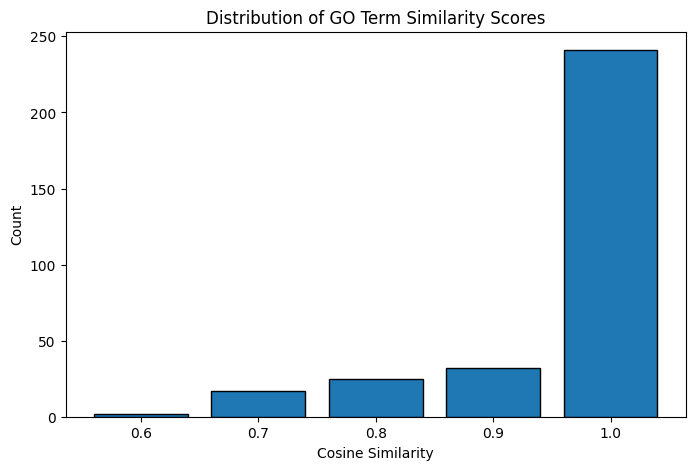

In [55]:
import matplotlib.pyplot as plt
from collections import Counter

# Suppose matched_terms is your dictionary of gene predictions (from auto_match_go_terms)
# where each value is a list of dictionaries with a key 'similarity'
similarity_scores = []
for gene, matches in matched_terms.items():
    for match in matches:
        similarity_scores.append(match['similarity'])

# Bin the similarity scores, e.g., rounded to one decimal place.
binned_scores = [round(score, 1) for score in similarity_scores]
score_counts = Counter(binned_scores)

# Prepare data for the bar plot.
bins = sorted(score_counts.keys())
counts = [score_counts[b] for b in bins]

plt.figure(figsize=(8, 5))
plt.bar(bins, counts, width=0.08, edgecolor='black')
plt.xlabel('Cosine Similarity')
plt.ylabel('Count')
plt.title('Distribution of GO Term Similarity Scores')
plt.xticks(bins)
plt.show()


6.2.
Need to make a new scoring system: possibly True Positive (what we found), Nobel Positive (NP), Not Detected